In [22]:
import torch
from PIL import Image
import open_clip

from datasets import load_dataset, concatenate_datasets

import matplotlib.pyplot as plt

In [24]:
batched_dataset = load_dataset("SigLIP-forge/reddit-malelivingspace-captioned")
all_batches = [ds for name, ds in batched_dataset.items() if name.startswith("batch")]
dataset = concatenate_datasets(all_batches)
dataset

Dataset({
    features: ['post_id', 'title', 'top_comments', 'images', 'caption_gemma', 'caption_qwen'],
    num_rows: 1740
})

In [8]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

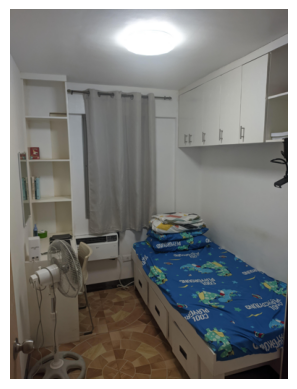

In [12]:
sample = next(iter(dataset["batch_42"]))

image = sample["images"][0]

plt.axis("off")
plt.imshow(image)

In [13]:
text = list(dataset["batch_42"]["caption_qwen"])
text

['The room includes warm lighting, a carpeted floor, an accent wall near the fan, a colorful drape, decorations in shelves, a dim lamp, a ceiling fan, a rug, plants, and a comfortable bed.',
 'Accent chair, IKEA chair in bedroom, Coze recliner, Swivel chair, and a TV on roof.',
 'a corner with a safe, safe guy meme, big plant, and casters, chair moved away from the sloped ceiling.',
 'A living room with vibrant color schemes, a black couch, OBEY posters, and pillows, featuring a clean, functional layout.',
 '<think>\nOkay, let\'s tackle this. The user wants me to extract the decor elements and infer the room layout from the comments. They specified not to include any introductory phrases or explanations, just the caption itself. Also, avoid hashtags and questions.\n\nFirst, I need to parse each comment. Let\'s see:\n\n1. "My de-stress room when the going get tough." So the room is for stress, maybe a relaxing space. The decor here might be white lighting, which is mentioned. The room i

In [19]:
t_image = preprocess(image).unsqueeze(dim=0)

with torch.no_grad(), torch.autocast("cuda"):
    image_features = model.encode_image(t_image)
    image_features /= image_features.norm(dim=-1, keepdim=True)

print(image_features)
print(image_features.shape)

tensor([[ 2.4458e-02, -5.8773e-03,  2.4827e-02, -6.1059e-03, -2.9007e-02,
         -1.9213e-02,  1.9147e-02, -3.6899e-02, -1.2628e-02,  3.4128e-02,
          1.9529e-02, -4.2250e-02,  2.5002e-02, -2.0330e-02,  8.5173e-03,
         -1.0423e-02, -5.9939e-02,  1.2680e-02,  1.5706e-02,  4.6593e-03,
          2.9651e-03, -2.4031e-02,  1.6930e-03, -3.2619e-02, -1.0808e-02,
          4.8133e-02, -1.3332e-03, -8.8468e-03, -8.8795e-02,  4.6912e-02,
          9.2474e-02, -3.1419e-02,  1.3032e-02,  7.4067e-02,  3.7403e-03,
         -1.8934e-02, -1.2955e-02,  4.8032e-02,  3.6525e-02,  6.5882e-02,
         -5.6998e-02, -3.3622e-02,  6.6562e-02, -5.6282e-02, -1.1221e-02,
         -1.2694e-03,  3.9523e-02,  2.0059e-02,  1.2559e-02, -1.0871e-02,
          1.9900e-02, -6.5174e-02,  1.0307e-02, -1.8090e-02, -4.4696e-02,
          1.7416e-02, -3.0897e-02,  1.1653e-02,  1.0410e-02, -1.2027e-02,
          2.6151e-03, -2.4783e-02,  2.0411e-02,  2.3303e-02, -2.4758e-03,
          3.9048e-03,  1.3685e-02,  5.

In [20]:
from transformers import pipeline

llama = pipeline("text-generation", model="meta-llama/Llama-3.2-1B-Instruct")

Device set to use cuda:0


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Model + Tokenizer Names ---
clip_name = "openai/clip-vit-base-patch32"
llm_name = "meta-llama/Llama-3.2-1B-Instruct"

# --- Hyperparams ---
batch_size = 8
epochs = 5
lr = 1e-4
max_length = 50
projected_seq_len = 1

# --- Load Models ---
clip_model = CLIPModel.from_pretrained(clip_name).eval().to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_name)

llm = AutoModelForCausalLM.from_pretrained(llm_name).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token

# --- Projector ---
class ClipProjector(nn.Module):
    def __init__(self, in_dim=512, out_dim=768, seq_len=1):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim * seq_len)
        self.seq_len = seq_len
        self.out_dim = out_dim

    def forward(self, x):
        x = self.linear(x)
        return x.view(-1, self.seq_len, self.out_dim)

projector = ClipProjector(in_dim=512, out_dim=llm.config.hidden_size, seq_len=projected_seq_len).to(device)
optimizer = torch.optim.AdamW(projector.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# --- Image transform (not strictly needed with CLIPProcessor, but you can control it) ---
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def compute_clip_embedding(images):
    pil_images = [Image.open(img["path"]).convert("RGB") for img in images]
    inputs = clip_processor(images=pil_images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        img_feats = clip_model.get_image_features(**inputs)  # [n, 512]
    return img_feats.mean(dim=0)  # [512]

# --- Training function ---
def train_on_caption(caption_key):
    projector.train()
    for epoch in range(epochs):
        total_loss = 0
        for example in dataset.shuffle().select(range(500)):  # adjust range as needed
            caption = example[caption_key]
            if not caption.strip():
                continue  # skip empty

            image_embed = compute_clip_embedding(example["images"]).unsqueeze(0)  # [1, 512]
            projected = projector(image_embed)  # [1, seq_len, hidden]

            cap_inputs = tokenizer(caption, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
            cap_input_ids = cap_inputs.input_ids
            cap_labels = cap_input_ids.clone()

            with torch.no_grad():
                cap_embeds = llm.transformer.wte(cap_input_ids)

            full_input = torch.cat([projected, cap_embeds], dim=1)
            full_labels = torch.cat([
                torch.full((1, projected_seq_len), -100).to(device),
                cap_labels
            ], dim=1)

            outputs = llm(inputs_embeds=full_input, labels=full_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        print(f"[{caption_key}] Epoch {epoch + 1}: Loss = {total_loss:.4f}")

# --- Train once with gemma, once with qwen ---
train_on_caption("caption_gemma")
train_on_caption("caption_qwen")


pytorch_model.bin:   3%|3         | 21.0M/605M [00:00<?, ?B/s]

KeyboardInterrupt: 